In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import argparse
import os
import sys

from data_processing import generate_data
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

In [3]:
TIMESTEPS = 3
BATCH_SIZE = 100
X, y = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS, seperate=False, transpose=False)

In [6]:
print(X['train'].shape)
print(X['val'].shape)
print(X['test'].shape)
print(X['train'][0])

(8097, 3, 1)
(897, 3, 1)
(997, 3, 1)
[[ 0.        ]
 [ 0.01000083]
 [ 0.02000067]]


In [7]:
print(y['train'].shape)
print(y['val'].shape)
print(y['test'].shape)

(8097, 1)
(897, 1)
(997, 1)


In [8]:
y1 = [v[0] for v in X['train']]
x1 = np.linspace(0,100,10000)[:len(y1)]
print(x1)

[  0.00000000e+00   1.00010001e-02   2.00020002e-02 ...,   8.09480948e+01
   8.09580958e+01   8.09680968e+01]


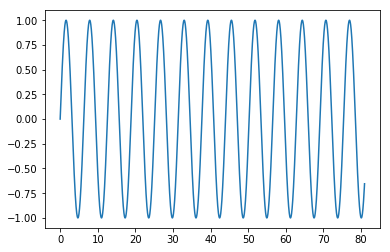

In [9]:
plt.plot(x1, y1)
plt.show()

In [10]:
train_iter = mx.io.NDArrayIter(X['train'], y['train'], batch_size=BATCH_SIZE, shuffle=True, label_name='lro_label')
eval_iter = mx.io.NDArrayIter(X['val'], y['val'], batch_size=BATCH_SIZE, shuffle=False)
test_iter = mx.io.NDArrayIter(X['test'], batch_size=BATCH_SIZE, shuffle=False)
print("X: \n",X['train'], "\ny:\n", y['train'])

X: 
 [[[ 0.        ]
  [ 0.01000083]
  [ 0.02000067]]

 [[ 0.01000083]
  [ 0.02000067]
  [ 0.0299985 ]]

 [[ 0.02000067]
  [ 0.0299985 ]
  [ 0.03999333]]

 ..., 
 [[-0.6693356 ]
  [-0.66187191]
  [-0.654342  ]]

 [[-0.66187191]
  [-0.654342  ]
  [-0.6467467 ]]

 [[-0.654342  ]
  [-0.6467467 ]
  [-0.63908666]]] 
y:
 [[ 0.0299985 ]
 [ 0.03999333]
 [ 0.04998416]
 ..., 
 [-0.6467467 ]
 [-0.63908666]
 [-0.63136274]]


In [14]:
num_layers = 3
num_hidden = 50

data = mx.sym.Variable('data')
label = mx.sym.Variable('lro_label')

stack = mx.rnn.SequentialRNNCell()
for i in range(num_layers):
    stack.add(mx.rnn.LSTMCell(num_hidden=num_hidden, prefix='lstm_l%d_'%i))
#stack.reset()
outputs, states = stack.unroll(length=TIMESTEPS,
                               inputs=data,
                               layout='NTC',
                               merge_outputs=True)

# unroll output shape: (batch_size, sequence_length, hidden_dim) @ NTC, or (100, 5, 50)

outputs = mx.sym.reshape(outputs, shape=(BATCH_SIZE, -1))
outputs = mx.sym.FullyConnected(data=outputs, num_hidden=1, name='fc1')
label = mx.sym.reshape(label, shape=(-1,))
outputs = mx.sym.LinearRegressionOutput(data=outputs, 
                               label=label,
                               name='lro')
#mx.viz.plot_network(outputs)


In [15]:
contexts = mx.cpu(0)

model = mx.mod.Module(symbol = outputs,
                     data_names = ['data'],
                     label_names = ['lro_label'])

In [16]:
model.fit(train_iter, eval_iter,
         optimizer_params = {'learning_rate':0.005},
         num_epoch=4,
         batch_end_callback=mx.callback.Speedometer(BATCH_SIZE, 2))

infer_shape error. Arguments:
  data: (100, 3, 1)
  lro_label: (100, 1)


MXNetError: Error in operator lro: Shape inconsistent, Provided=(100,), inferred shape=(100,150)

In [ ]:
predicted = model.predict(eval_iter).asnumpy()
metric = mx.metric.MSE()
model.score(eval_iter, metric)
print(predicted.shape)
print(y['test'].shape)

In [23]:
print(predicted)

<NDArray 895x20 @cpu(0)>


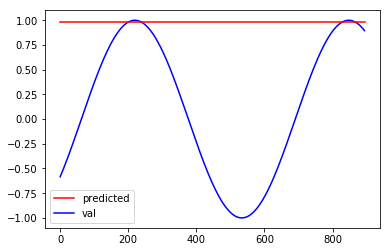

In [15]:
predicted_y = [x[0] for x in predicted]
plot_test, = plt.plot(y['val'], label='val', color="blue")
plot_predicted, = plt.plot(predicted_y, label='predicted', color="red")
plt.legend(handles=[plot_predicted, plot_test])